<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week2_1_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ch.7 앙상블 학습과 랜덤 포레스트

- **앙상블학습**(ensemble learning): 예측기(분류나 회귀 모델)로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 얻도록 하는 일련의 예측기
- **앙상블 방법**(ensemble method): 앙상블 학습 알고리즘



---



#### **7.1** 투표 기반 분류기

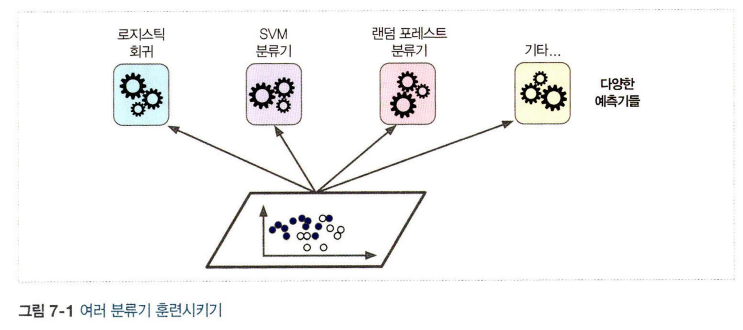

- **직접 투표**(hard voting) 분류기: 다수결 투표로 정해지는 분류기

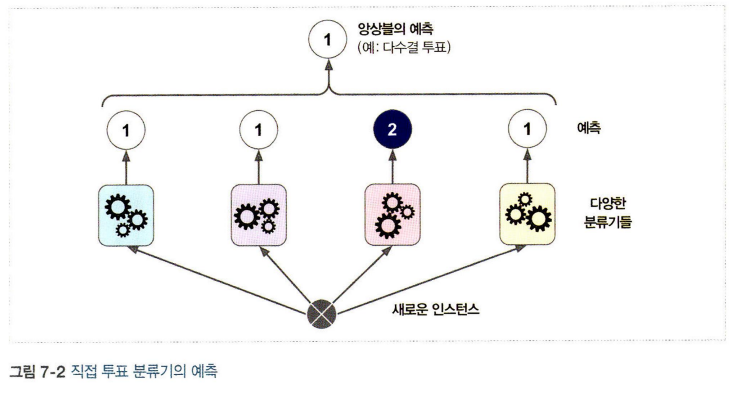

- 약한 학습기(weak learner): 랜덤 추측보다 조금 더 높은 성능을 내는 분류기
- 강한 학습기(strong learner): 높은 정확도를 내는 분류기


분류기들은 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮음

-> 앙상블 방법은 예측기가 가능한 서로 독립적일 때 최고의 성능을 발휘

-> 각기 다른 알고리즘으로 학습시켜 다양한 분류기를 얻을 수 있음: 매우 다른 종류의 오차

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.9
SVC 0.85
VotingClassifier 0.85


- **간점 투표**(soft voting): 모든 분류기가 클래스의 확률을 예측할 수 있으면(predict_proba() 메서드가 있음) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측
- voting="hard" 를 voting="soft" 로 바꿔야 함



---



#### **7.2** 배깅과 페이스팅

- **배깅**(bagging): 훈련 세트에서 중복을 허용하여 샘플링하는 방식(bootstrap aggregating의 줄임말)
- **페이스팅**(pasting): 중복을 허용하지 않고 샘플링하는 방식

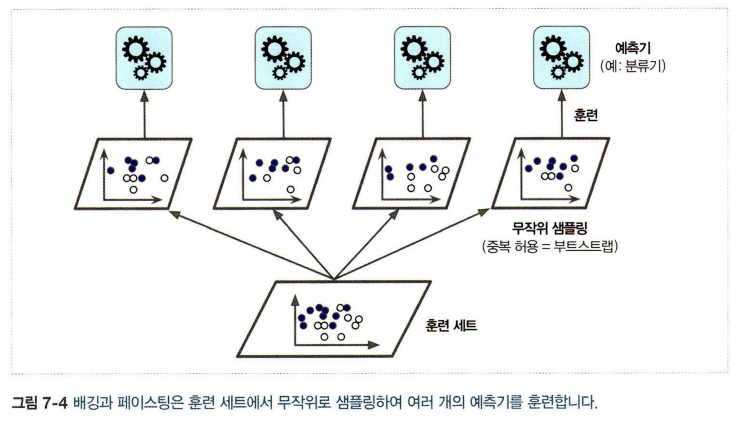

- 앙상블이 모든 예측기의 예측을 모다 새로운 샘플에 대한 예측을 만듦
- 전형적 분류의 경우 *통계적 최빈값*이 수집 함수이고, 회귀에 대해서는 평균을 계산
- *일반적으로* 앙상블의 결과 => 편향은 비슷하지만 분산은 감소

##### **7.2.1 사이킷런의 배깅과 페이스팅**

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

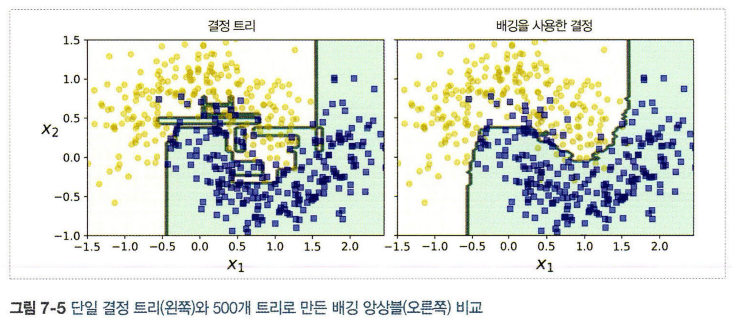

- 배깅이 전반적으로 더 나은 모델을 만듦
- 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅 모두 평가하는 것이 좋음

##### **7.2.2 obb 평가**

*BaggingClassifier*: 기본값으로 중복을 허용하여(bootstrap=True) 훈련 세트의 크기만큼인 m개의 샘플을 선택
- 예측기가 훈련되는 동안 obb 샘플 사용 X => obb 샘플 사용해서 평가 가능

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9125

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [7]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.01666667, 0.98333333],
       [0.03517588, 0.96482412],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.19892473, 0.80107527],
       [0.95428571, 0.04571429],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.05583756, 0.94416244],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.14213198, 0.85786802],
       [0.        , 1.        ],
       [0.25443787, 0.74556213],
       [0.88461538, 0.11538462],
       [0.        , 1.        ],
       [0.27810651, 0.72189349],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.00540541, 0.99459459],
       [0.99435028, 0.00564972],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.



---



#### **7.3** 랜덤 패치와 랜덤 서브스페이스

- **랜덤 패치 방식**(random pathes method): 훈련 특성과 샘플을 모두 샘플링하는 것
- **랜덤 서브스페이스 방식**(random subspaces method): 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것



---



#### **7.4** 랜덤 포레스트

- 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 트리의 노드를 분할할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입
- 더 다양한 트리를 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델 만듦

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

##### **7.4.1 엑스트라 트리**

트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 최상의 분할을 선택

- **익스트림 랜덤 트리**(extremely randomized trees): 극단적으로 무작위한 트리의 랜덤 포레스트
- 편향이 늘어나지만 대신 분산을 낮추게 됨

##### **7.4.2 특성 중요도**

- 특성의 상대적 중요도 측정하기 쉬움
- 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성 중요도 측정 = 가중치 평균
- 각 노드의 가중치 = 연관된 훈련 샘플의 수

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10293724602808133
sepal width (cm) 0.02759854284702566
petal length (cm) 0.4451540983201621
petal width (cm) 0.42431011280473085


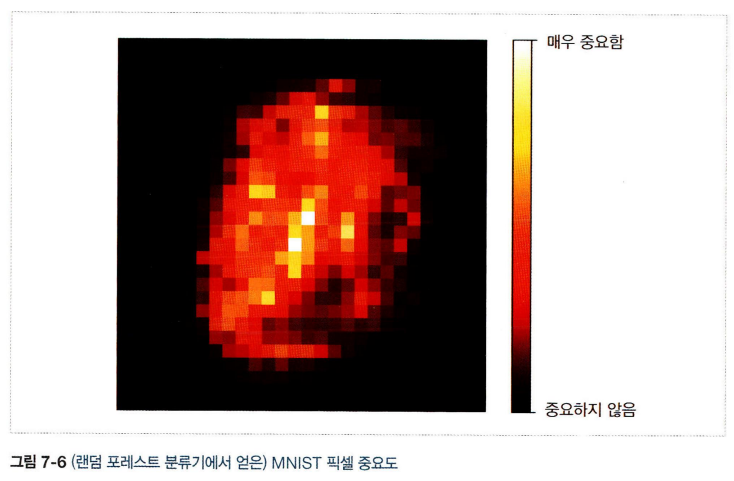